In [1]:
# !pip install country_converter

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import country_converter as coco

import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import iplot
from PIL import Image
import requests

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

### Load datasets

In [3]:
books = pd.read_csv("Books.csv")
ratings = pd.read_csv("Ratings.csv")
users = pd.read_csv("Users.csv")

In [4]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


### EDA

In [7]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [10]:
# Display the shape of the datasets
def shape_of_dataset(df, dataset_name):
    print(f"{dataset_name} dataset has {df.shape[0]} columns and {df.shape[1]} rows")
    return df.shape[0], df.shape[1]

In [11]:
books_r, books_c = shape_of_dataset(books, "Books")
ratings_r, ratings_c = shape_of_dataset(ratings, "Ratings")
users_r, users_c = shape_of_dataset(users, "Users")

Books dataset has 271360 columns and 8 rows
Ratings dataset has 1149780 columns and 3 rows
Users dataset has 278858 columns and 3 rows


In [12]:
# Display the total number of null values in dataframes

def null_values_in_df(df, dataset_name):
    total_num_null_values = df.isnull().sum().sum()
    print(f"{dataset_name} dataset has {total_num_null_values} null values")
    return total_num_null_values


In [13]:
books_null = null_values_in_df(books, "Books")
ratings_null = null_values_in_df(ratings, "Ratings")
users_null = null_values_in_df(users, "Users")

Books dataset has 7 null values
Ratings dataset has 0 null values
Users dataset has 110762 null values


In [14]:
# Detect the null cols in the dataframes

def null_cols_in_df(df, dataset_name):
    null_cols = df.columns[df.isnull().any()]
    print(f"{dataset_name} dataset has {len(null_cols)} columns with null values: {null_cols.tolist()}")
    return null_cols.to_list(), len(null_cols)


In [15]:
# def null_cols_in_df(df, dataset_name):
    
#     col = []
#     s = df.isnull().sum()
#     for x in range(len(s)):
#         if s[x] > 0:
#             col.append(s.index[x])
#     tot_cols = len(col)
#     if tot_cols == 0:
#         print(f"{dataset_name} dataset has no null columns")
#         print("="*50)
#     else:
#         print(f"{dataset_name} dataset has {tot_cols} null columns and they are:")
#         for x in col:
#             print(x, end=',')
#         print()
#         print("="*50)
#     return col, len(col)

In [16]:
total_books_null_cols, books_null_cols = null_cols_in_df(books, "Books")
total_ratings_null_cols, ratings_null_cols = null_cols_in_df(ratings, "Ratings")
total_users_null_cols, users_null_cols = null_cols_in_df(users, "Users")

Books dataset has 3 columns with null values: ['Book-Author', 'Publisher', 'Image-URL-L']
Ratings dataset has 0 columns with null values: []
Users dataset has 1 columns with null values: ['Age']


In [17]:
total_books_null_cols

['Book-Author', 'Publisher', 'Image-URL-L']

In [18]:
books_null_cols

3

In [19]:
# comparison between datasets
detailed_db = pd.DataFrame({
    'dataset' : [],
    'nrows' : [],
    'ncols' :[],
    'null_amount' : [],
    'names_of_null_cols' : [],
    'num_null_cols' : []
})

def fill_db_dataset(dataset_name, nrows, ncols, null_amount, name_null_cols, num_null_cols):
    detailed_db.loc[len(detailed_db.index)] = [dataset_name, nrows, ncols, null_amount, ', '.join(name_null_cols), int(num_null_cols)]

In [20]:
fill_db_dataset('Books', books_r, books_c, books_null, total_books_null_cols, books_null_cols)
fill_db_dataset('Ratings', ratings_r, ratings_c, ratings_null, total_ratings_null_cols, ratings_null_cols)
fill_db_dataset('Users', users_r, users_c, users_null, total_users_null_cols, users_null_cols)

In [21]:
detailed_db

,dataset,nrows,ncols,null_amount,names_of_null_cols,num_null_cols
0,Books,271360,8,7,"Book-Author, Publisher, Image-URL-L",3
1,Ratings,1149780,3,0,,0
2,Users,278858,3,110762,Age,1


In [22]:
# Plot missing values

def missing_values_plot(df, dataset_name):
    msno.matrix(df, figsize=(10, 5), labels=True)
    plt.title(f"Missing Values in {dataset_name} dataset")
    plt.show()

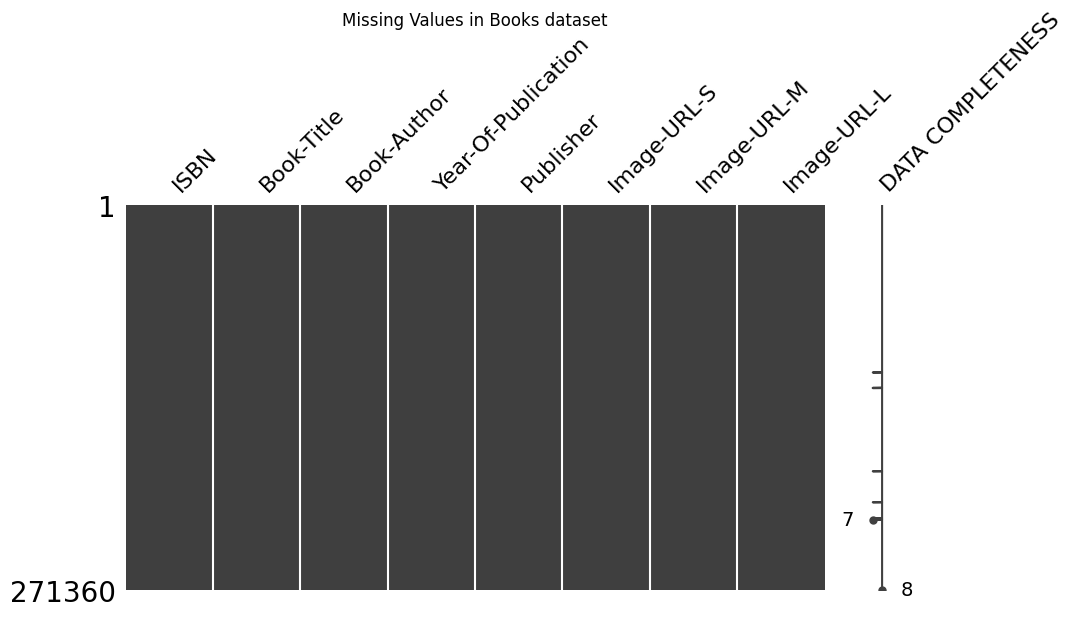

In [23]:
missing_values_plot(books, "Books")

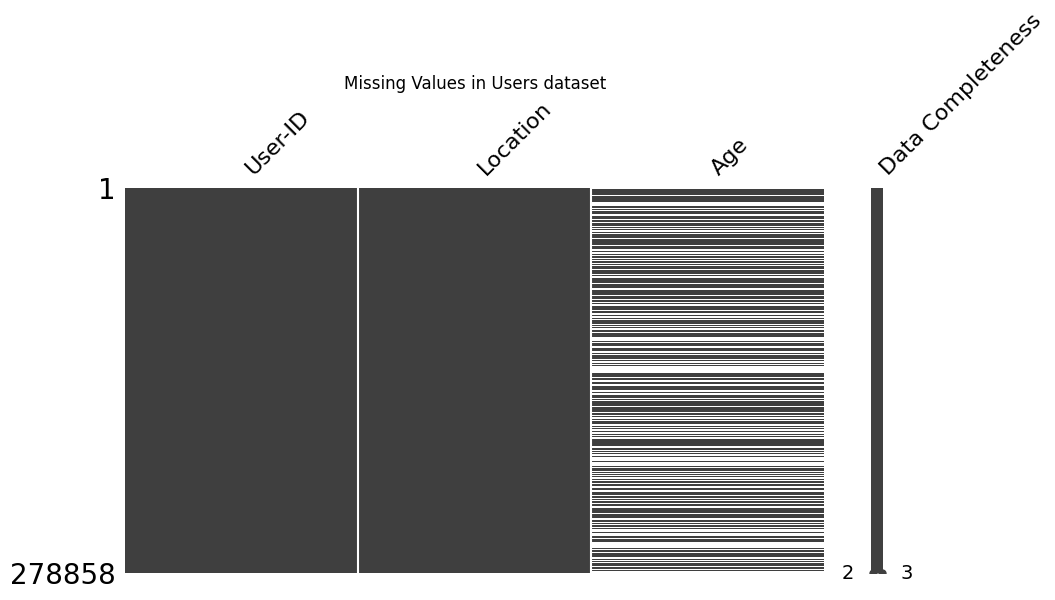

In [24]:
missing_values_plot(users, "Users")

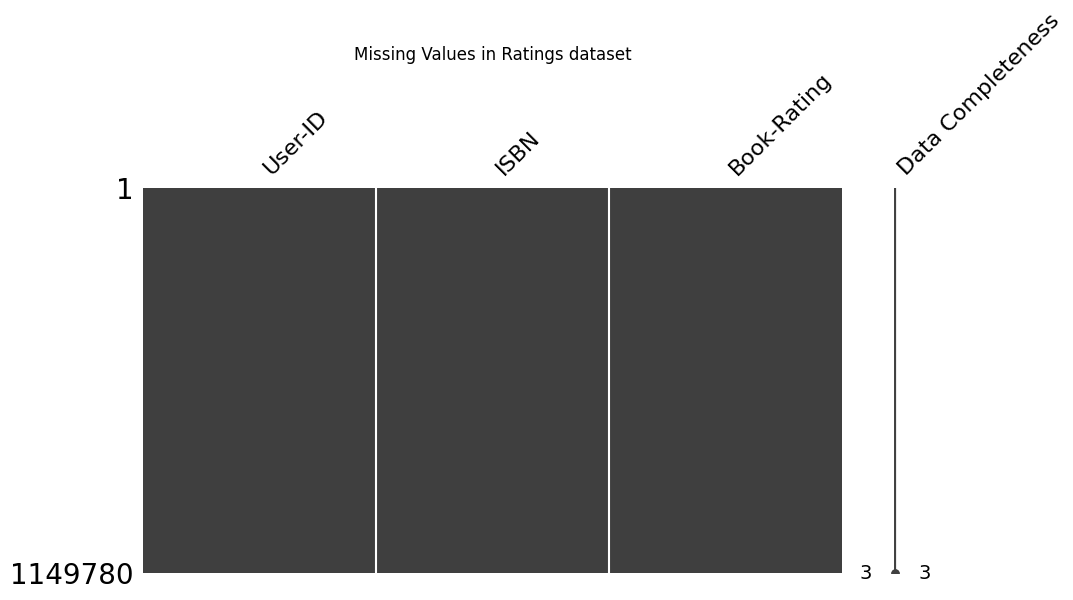

In [25]:
missing_values_plot(ratings, "Ratings")

In [26]:
# EDA + Visualization
def plot_top20(df, column, title, x_label, y_label, top=20, template = 'plotly_dark'):
    
    pl = df[column].value_counts().head(top)
    fig = px.bar(y=pl.values, 
                 x=pl.index, 
                 color_discrete_sequence=px.colors.sequential.PuBuGn,
                 text=pl.values,
                 title= title,
                 template= template)
    fig.update_layout(
        xaxis_title=x_label,
        yaxis_title=y_label,
        font = dict(size=15,family="Franklin Gothic"))
    fig.show()

In [27]:
books['Year-Of-Publication'].astype('int32')

ValueError: invalid literal for int() with base 10: 'DK Publishing Inc'

In [30]:
# Replace non-numeric values with NaN
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')
books['Year-Of-Publication'].fillna(0, inplace=True)

# books.dropna(subset=['Year-Of-Publication'], inplace=True)

books['Year-Of-Publication'] = books['Year-Of-Publication'].astype('int32')


In [31]:
plot_top20(books, \
           'Year-Of-Publication', 'Top 20 years in which books were published in terms of count', "Year", "Count")

In [32]:
books["Year-Of-Publication"].value_counts().head(20)

Year-Of-Publication
2002    17627
1999    17431
2001    17359
2000    17232
1998    15766
1997    14890
2003    14358
1996    14030
1995    13546
1994    11796
1993    10602
1992     9906
1991     9389
1990     8660
1989     7936
1988     7492
1987     6529
1986     5841
2004     5839
1985     5343
Name: count, dtype: int64

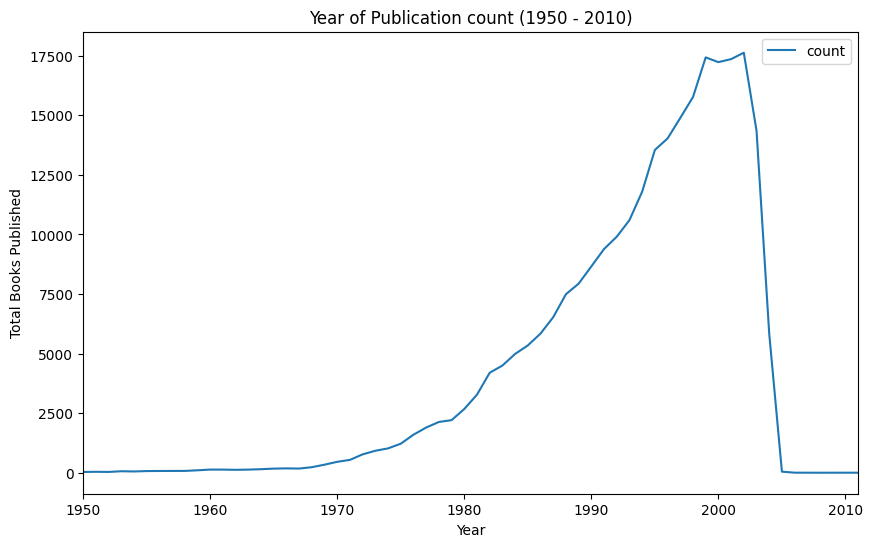

In [34]:
year_count=books['Year-Of-Publication'].value_counts()
year_count=pd.DataFrame(year_count)

plt.figure(figsize=(10, 6))
sns.lineplot(data=year_count)
plt.title('Year of Publication count (1950 - 2010)')
plt.xlim(1950, 2011)
plt.xlabel('Year')
plt.ylabel('Total Books Published')
plt.show()

In [35]:
plot_top20(books, 'Book-Author', "Top 20 Authors authored books by count", "Author name", "Count")

In [36]:
plot_top20(books, 'Publisher', "Top 20 Publishers who have published books", "Publisher name", "Count")

### Let's extract the country from location column in the users dataset

In [37]:
countries = []
cond = users['Location'].str.split(',')

for cont in cond:
    countries.append(cont[-1])

In [ ]:
# converted_country=coco.convert(users['Country'], to="ISO2")
# converted_country
# users["Country"] = converted_country

In [ ]:
country=users["Country"].value_counts()
fig=px.choropleth(locations=country.index,
                  color=country.values,
                  color_continuous_scale=px.colors.sequential.dense,
                  template='plotly_dark',
                  title='Distribution of users by countries')

fig.update_layout(font=dict(size=17, family="Franklin Gothic"))
fig.show()